In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import numpy as np

warnings.filterwarnings('ignore')

In [3]:
dataset = 'https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset?select=IN_youtube_trending_data.csv'

final_dir = '\\'.join(os.getcwd().split('\\')[:-1])

In [4]:
od.download(dataset, data_dir=final_dir)

final_dir += '\\youtube-trending-video-dataset\\IN_youtube_trending_data.csv'

Skipping, found downloaded files in "C:\Users\timbe\Final Project\youtube-trending-video-dataset" (use force=True to force download)


In [35]:
data = pd.read_csv(final_dir)

data.head(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Iot0eF6EoNA,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,2020-08-12T04:31:41Z,UCGqvJPRcv7aVFun-eTsatcA,FoxStarHindi,24,2020-08-12T00:00:00Z,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,224925,3979409,350210,https://i.ytimg.com/vi/Iot0eF6EoNA/default.jpg,False,False,Three Streams. Three Stories. One Journey. Sta...
1,x-KbnJ9fvJc,Kya Baat Aa : Karan Aujla (Official Video) Tan...,2020-08-11T09:00:11Z,UCm9SZAl03Rev9sFwloCdz1g,Rehaan Records,10,2020-08-12T00:00:00Z,[None],11308046,655450,33242,405146,https://i.ytimg.com/vi/x-KbnJ9fvJc/default.jpg,False,False,Singer/Lyrics: Karan Aujla Feat Tania Music/ D...
2,KX06ksuS6Xo,Diljit Dosanjh: CLASH (Official) Music Video |...,2020-08-11T07:30:02Z,UCZRdNleCgW-BGUJf-bbjzQg,Diljit Dosanjh,10,2020-08-12T00:00:00Z,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,296533,6179,30058,https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg,False,False,CLASH official music video performed by DILJIT...


In [36]:
# Checking the shape of the DataFrame
data.shape

(177621, 16)

In [37]:
# Dropping ID columns as they are not necessary for the analysis and prediction

data.drop(['video_id', 'channelId'], axis = 1, inplace = True)

# Validating the above code

data.head(3)

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,2020-08-12T04:31:41Z,FoxStarHindi,24,2020-08-12T00:00:00Z,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,224925,3979409,350210,https://i.ytimg.com/vi/Iot0eF6EoNA/default.jpg,False,False,Three Streams. Three Stories. One Journey. Sta...
1,Kya Baat Aa : Karan Aujla (Official Video) Tan...,2020-08-11T09:00:11Z,Rehaan Records,10,2020-08-12T00:00:00Z,[None],11308046,655450,33242,405146,https://i.ytimg.com/vi/x-KbnJ9fvJc/default.jpg,False,False,Singer/Lyrics: Karan Aujla Feat Tania Music/ D...
2,Diljit Dosanjh: CLASH (Official) Music Video |...,2020-08-11T07:30:02Z,Diljit Dosanjh,10,2020-08-12T00:00:00Z,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,296533,6179,30058,https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg,False,False,CLASH official music video performed by DILJIT...


In [38]:
# Checking null values

def null_values(df):
    temp = df.isna().sum()
    temp_1 = round(temp * 100 / df.shape[0], 2)
    
    return pd.DataFrame((temp, temp_1), index = ['Count', 'Percentage']).T.sort_values('Count', ascending = False)


null_values(data)

,Count,Percentage
description,17210.0,9.69
channelTitle,1.0,0.00
title,0.0,0.00
publishedAt,0.0,0.00
categoryId,0.0,0.00
trending_date,0.0,0.00
tags,0.0,0.00
view_count,0.0,0.00
likes,0.0,0.00
dislikes,0.0,0.00


We can see that there are around 10% missing values in `description` column and only 1 missing value in `channelTitle` column.
- We shall keep the `description` column as it is while analysis and do the null value treatment during model building.
- We shall delete one row from which has the null value in `channelTitle` column.

In [39]:
# Deleting one row where there is null value in 'channelTitle' column

data.dropna(subset = ['channelTitle'], how = 'any', inplace = True)

# Validating the above code

null_values(data).loc['channelTitle',:]

Count         0.0
Percentage    0.0
Name: channelTitle, dtype: float64

In [40]:
# Let's check the datatypes of each column in DataFrame

data.dtypes

title                object
publishedAt          object
channelTitle         object
categoryId            int64
trending_date        object
tags                 object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
thumbnail_link       object
comments_disabled      bool
ratings_disabled       bool
description          object
dtype: object

- `publishedAt`, `trending_date` are object type. Let's convert it to Datetime format.

In [41]:
# Converting 'publishedAt' and 'trending_date' to datetime objects

data['publishedAt'] = pd.to_datetime(data['publishedAt'])
data['trending_date'] = pd.to_datetime(data['trending_date'])

# Validating the above changes

data.dtypes[['publishedAt', 'trending_date']]

publishedAt      datetime64[ns, UTC]
trending_date    datetime64[ns, UTC]
dtype: object

In [42]:
# Getting new column 'daysTakenToTrend' which gives us the information about the number of days taken by the video to get into the trending videos

data['daysTakenToTrend'] = (data['trending_date'] - data['publishedAt']).dt.days

# Validating the above code

data.head(3)

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,daysTakenToTrend
0,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,2020-08-12 04:31:41+00:00,FoxStarHindi,24,2020-08-12 00:00:00+00:00,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,224925,3979409,350210,https://i.ytimg.com/vi/Iot0eF6EoNA/default.jpg,False,False,Three Streams. Three Stories. One Journey. Sta...,-1
1,Kya Baat Aa : Karan Aujla (Official Video) Tan...,2020-08-11 09:00:11+00:00,Rehaan Records,10,2020-08-12 00:00:00+00:00,[None],11308046,655450,33242,405146,https://i.ytimg.com/vi/x-KbnJ9fvJc/default.jpg,False,False,Singer/Lyrics: Karan Aujla Feat Tania Music/ D...,0
2,Diljit Dosanjh: CLASH (Official) Music Video |...,2020-08-11 07:30:02+00:00,Diljit Dosanjh,10,2020-08-12 00:00:00+00:00,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,296533,6179,30058,https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg,False,False,CLASH official music video performed by DILJIT...,0


In [43]:
data['categoryId'].unique()

array([24, 10, 20, 23, 22, 25, 17,  1, 26, 28, 27,  2, 19, 29, 15],
      dtype=int64)

We can see that `categoryId` column has id's of repective categories. We can access the description of categoryId from the `US_category_id.json` file.

In [44]:
# Let's import US_category_id.json file and map the category id's respectively

category_path = '\\'.join(final_dir.split('\\')[:-1]) + '\\US_category_id.json'


# Creating a dictionary object which stores the category id and its respective category
category_dict = {}

with open(category_path, 'r') as file:
    json_data = json.load(file)
    for item in json_data['items']:
        category_dict[int(item['id'])] = item['snippet']['title']
    
data['categoryId'] = data['categoryId'].apply(lambda x: category_dict[x])

# Validating the above code
data['categoryId'].head()

0    Entertainment
1            Music
2            Music
3            Music
4            Music
Name: categoryId, dtype: object

<b> Note: </b>
- Although we were using IN data for analysis. The `IN_category_id.json` was missing some data.
- Upon research, we found out that the `id` and `title` are same irrespective of the country.
- Hence, we have used `US_category_id.json` in the above case.

In [45]:
# Checking the Dataframe after the changes

data.head()

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,daysTakenToTrend
0,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,2020-08-12 04:31:41+00:00,FoxStarHindi,Entertainment,2020-08-12 00:00:00+00:00,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,224925,3979409,350210,https://i.ytimg.com/vi/Iot0eF6EoNA/default.jpg,False,False,Three Streams. Three Stories. One Journey. Sta...,-1
1,Kya Baat Aa : Karan Aujla (Official Video) Tan...,2020-08-11 09:00:11+00:00,Rehaan Records,Music,2020-08-12 00:00:00+00:00,[None],11308046,655450,33242,405146,https://i.ytimg.com/vi/x-KbnJ9fvJc/default.jpg,False,False,Singer/Lyrics: Karan Aujla Feat Tania Music/ D...,0
2,Diljit Dosanjh: CLASH (Official) Music Video |...,2020-08-11 07:30:02+00:00,Diljit Dosanjh,Music,2020-08-12 00:00:00+00:00,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,296533,6179,30058,https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg,False,False,CLASH official music video performed by DILJIT...,0
3,Dil Ko Maine Di Kasam Video | Amaal M Ft.Ariji...,2020-08-10 05:30:49+00:00,T-Series,Music,2020-08-12 00:00:00+00:00,hindi songs|2020 hindi songs|2020 new songs|t-...,23564512,743931,84162,136942,https://i.ytimg.com/vi/UsMRgnTcchY/default.jpg,False,False,Gulshan Kumar and T-Series presents Bhushan Ku...,1
4,"Baarish (Official Video) Payal Dev,Stebin Ben ...",2020-08-11 05:30:13+00:00,VYRLOriginals,Music,2020-08-12 00:00:00+00:00,VYRL Original|Mohsin Khan|Shivangi Joshi|Payal...,6783649,268817,8798,22984,https://i.ytimg.com/vi/WNSEXJJhKTU/default.jpg,False,False,VYRL Originals brings to you ‘Baarish’ - the b...,0


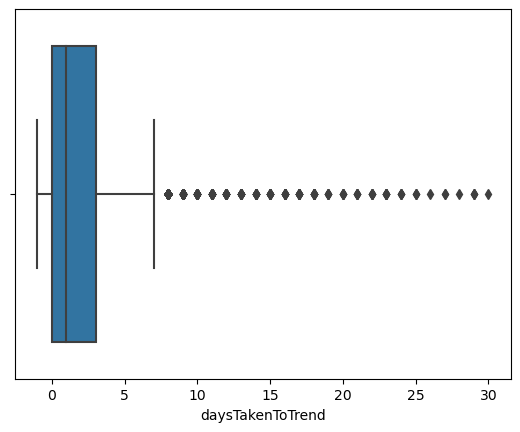

In [17]:
# Let's plot a Boxplot for 'daysTakenToTrend' column

sns.boxplot(data['daysTakenToTrend'])
plt.show()

There are some values less than 0. It is impossible for a video to trend before it was published.

<AxesSubplot:ylabel='Frequency'>

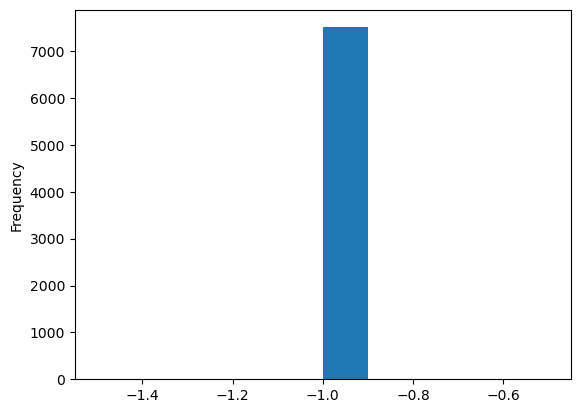

In [49]:
data[data['daysTakenToTrend'] < 0]['daysTakenToTrend'].plot.hist()

However, we can see that the negative days do no exceed -1.0. This might be because of some server lag or timezone difference. Let's conver those negative days to 0.

In [50]:
# Converting negative days in 'daysTakenToTrend' column to 0

data['daysTakenToTrend'] = data['daysTakenToTrend'].apply(lambda x: x if x>0 else 0)

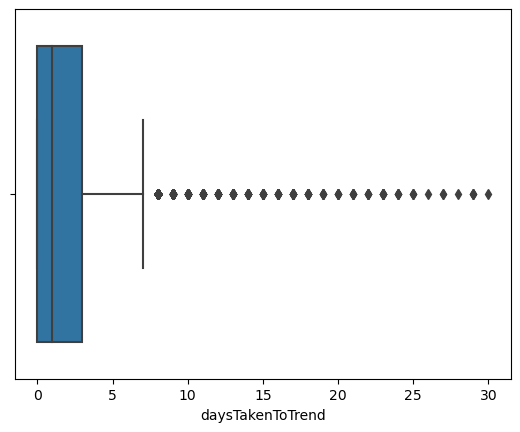

In [51]:
# Plotting boxplot after the changes

sns.boxplot(data['daysTakenToTrend'])
plt.show()

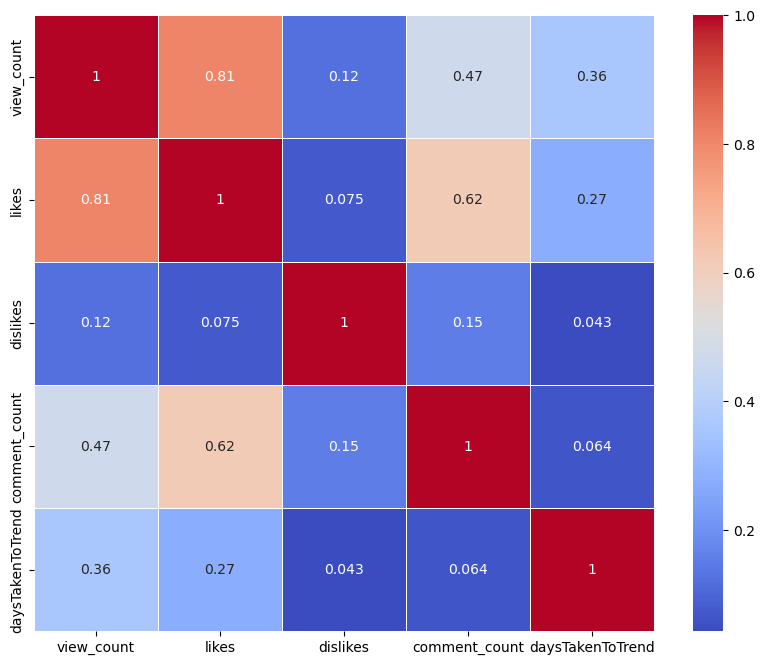

In [52]:
# Let's check the correlation between the numerical columns

plt.figure(figsize = (10, 8))
sns.heatmap(data[['view_count', 'likes', 'dislikes', 'comment_count', 'daysTakenToTrend']].corr(), linewidths=.5, annot=True, cmap='coolwarm')
plt.show()

- `view_count` and `likes` are highly correlated. It is more likely that the video with more views has more likes.
- `comment_count` and `likes` are relatively highly correlated when compared to `comment_count` and `views`.
- `daysTakenToTrend` is not correlated to any feature. Which is interesting as it is impossible to correlate how many days the video will take to trend based on comment_count or dislikes or likes or view_count.

In [53]:
######################### likes per view

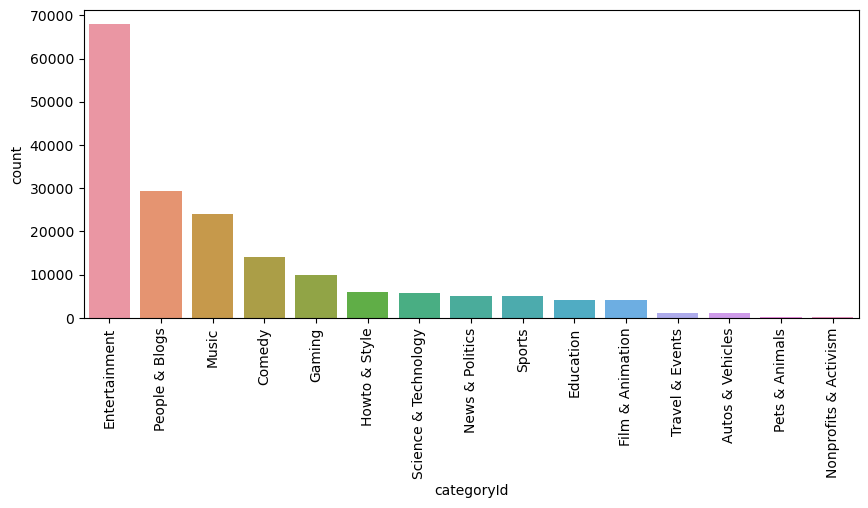

In [54]:
# Checking number of videos based on each Category

plt.figure(figsize = (10, 4))
sns.countplot(data['categoryId'], order = data['categoryId'].value_counts().sort_values(ascending = False).index)
plt.xticks(rotation = 90)
plt.show()

There are more `Entertainment` videos and least type is `Nonprofits & Activism`

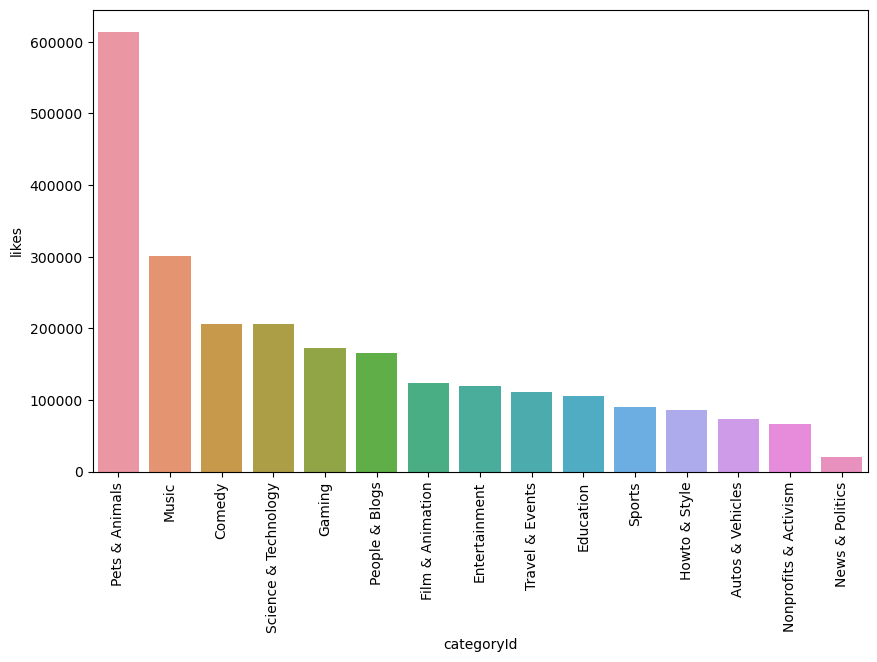

In [55]:
plt.figure(figsize = (10, 6))
sns.barplot(data = data, x = 'categoryId', y = 'likes',
            order = data.groupby('categoryId')['likes'].mean().sort_values(ascending = False).index, ci = 0)

plt.xticks(rotation = 90)
plt.show()

- `Pets & Animals` videos has most average likes and `New & Policts` videos has least average likes.

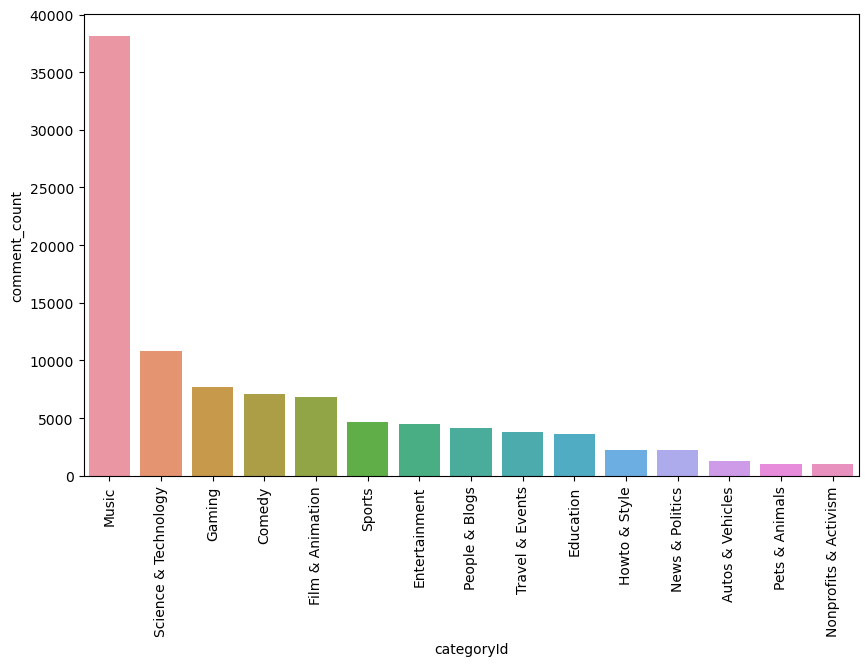

In [56]:
plt.figure(figsize = (10, 6))
sns.barplot(data = data, x = 'categoryId', y = 'comment_count',
            order = data.groupby('categoryId')['comment_count'].mean().sort_values(ascending = False).index, ci = 0)

plt.xticks(rotation = 90)
plt.show()

`Music` videos has most average comment count and `Nonprofits & Activism` has least average comment count.

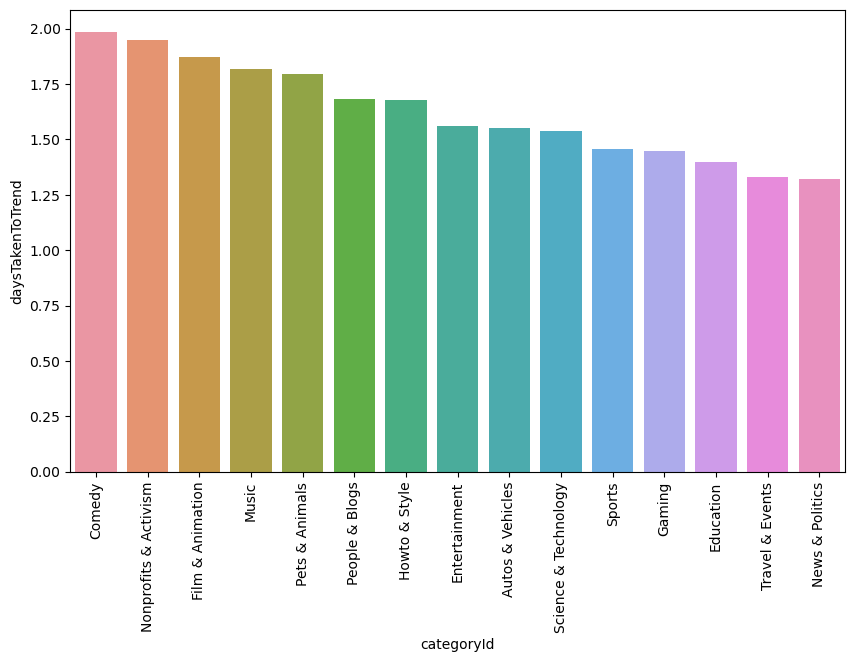

In [57]:
plt.figure(figsize = (10, 6))
sns.barplot(data = data, x = 'categoryId', y = 'daysTakenToTrend',
            order = data.groupby('categoryId')['daysTakenToTrend'].mean().sort_values(ascending = False).index, ci = 0)

plt.xticks(rotation = 90)
plt.show()

It is interesting to note that `News & Politics` videos take less time to trend and `Music`, `Comedy` and `Pets & Animals` videos take more time to trend.

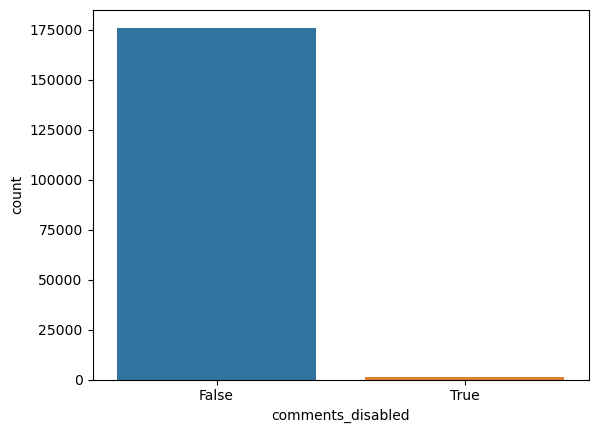

In [58]:
sns.countplot(data['comments_disabled'])
plt.show()

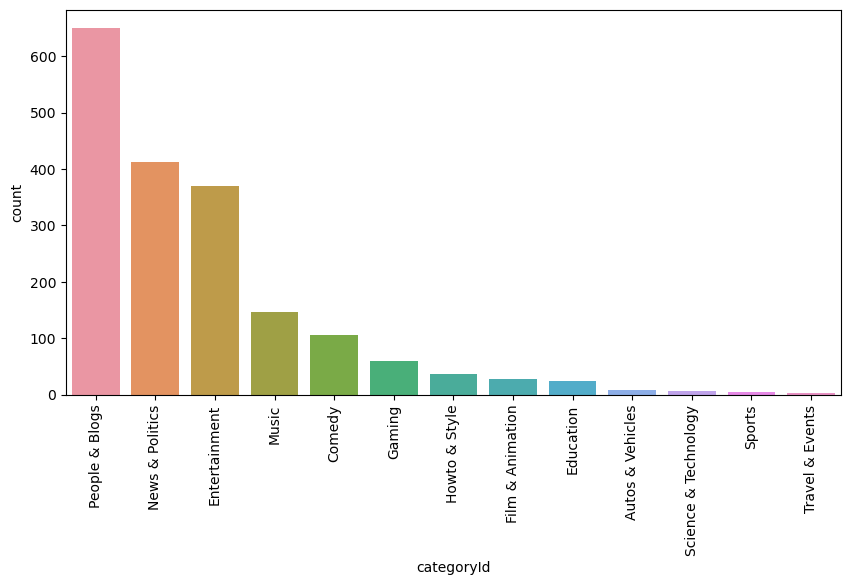

In [59]:
plt.figure(figsize = (10, 5))
sns.countplot(data[data['ratings_disabled'] == True]['categoryId'], 
              order = data[data['ratings_disabled'] == True].groupby('categoryId')['ratings_disabled'].count().sort_values(ascending = False).index)
plt.xticks(rotation = 90)
plt.show()